# COPD AI System

System Flow : 
1. Sleep Stage Classification(we need REM for the following steps)
2. ROH(Region of Hypoxia) Capture
3. TOI(Time-series to Image) transformation
4. Hybrid-NN model design

The first two steps are wrote in this file.

In [1]:
%matplotlib inline  
import csv
import time
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LeakyReLU
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
from keras import regularizers

import sys
import argparse

/home/d500dl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Global parameters setting.

In [2]:
'''
parser = argparse.ArgumentParser()
parser.add_argument("--n_retrain", help="retrain number, default is 0", default="0")
args = parser.parse_args()

n_retrain_user = args.n_retrain
'''
#--------------------------------
#num_retrain = int(n_retrain_user)
num_retrain = 0 #default is 0

ratio = 1.0 #Data augmentation if needed. 1.0 means no data augment.
each_part = ratio * 2000 #360000 #50000
start_from = 0 + each_part*num_retrain #Sometimes the frontal of data are mostly not 

## data preprocessing

Before we start any steps above, we have to get data from CSV file and do some preprocessing.

In [3]:
def get_data(path_to_dataset='/home/d500dl/EEG_107/COPD_RAWdata/2018_0515/PSG_SpO2_001.csv',
                           sequence_length=20,
                           ratio=1.0):

    t1 = time.time()

    with open(path_to_dataset, 'r') as f:
        reader = csv.reader(f)
        next(reader, None) # skip the headers
        #eeg_list = list(reader)

        channels=[]
        stages=[]
        spo2s=[]
        nb_values = 0
        row_cha=[]
        stage_mem=[0, 0, 0, 0, 0]
        spo2_mem=0
        n_roh=0
        ROH_i_list=[]
        Hypoxia_i_list=[]
        ostage=0
        for row in reader:
            if nb_values >= start_from : 
                if True:
                    ###print('no', nb_values)
                    try:
                        row_cha = [float(i) for i in row[1:5]]
                        channels.append(row_cha)
                        ##channels.append(row[2])
                        stage = [0, 0, 0, 0, 0]
                        spo2  = 0
                        if float(row[0])%1.0 == 0.0:
                            ###print('original stage:', row[-2])
                            ###print('original spo2 :', row[-1])
                            if row[-2] == '11': #Wake
                                stage[0] = 1
                            elif row[-2] == '12': #REM
                                stage[1] = 1
                            elif row[-2] == '13': #Stage1
                                stage[2] = 1
                            elif row[-2] == '14': #Stage2
                                stage[3] = 1
                            elif row[-2] == '15': #Stage3
                                stage[4] = 1
                            else:
                                stage = [0,0,0,0,0]
                                ostage += 1
                                #print('Other Stage!!', row[-2])
                            #keep the stage & SpO2 value to fill in missing value
                            stage_mem = stage
                            spo2 = float(row[-1])
                            spo2_mem = spo2
                        elif float(row[0])%1.0 != 0.0: #if time is not 
                            stage = stage_mem
                            spo2  = spo2_mem
                        else:
                            raise ValueError('Sophie: Format Error!')
                        ###print('stage:', stage)
                        ###print('spo2 :', spo2)
                        stages.append(stage)
                        spo2s.append(spo2)
                        if (stage==[0,1,0,0,0]) and (spo2 < 95.0):
                            ###print('ROH!!')
                            n_roh+=1
                            ROH_i_list.append(nb_values)
                        if spo2 < 95.0:
                            Hypoxia_i_list.append(nb_values)
                    except ValueError:
                        pass
            if nb_values >= (each_part + start_from):
                break
            nb_values+=1
            ###print('--------')
            #else:
            #    raise IOError("Input Error!")

    print("Data loaded from csv. Formatting...\n")
    print('Amount of stage 4:', ostage, '(There are 4 sleep stage + Wake + REM from old machine.)')
    print('Total ROH amount:', n_roh)
    print('Total ROH time:', float(n_roh)/200, '(s)')
    print('ROH index list check:', len(ROH_i_list))

    t2 = time.time()

    print('Total time slice amount:', len(channels))
    #print('Loaded:',len(channels), len(stages), len(spo2s))
    #print('channels:',len(channels[1]), len(stages[1]))
    print('Total data loading time:', t2-t1, '(s)')

    #t3 = time.time()
    """
    print('data imported time:', t2-t1)
    print('-----------------------------')
    print(channels[0], stages[0], spo2s[0])
    print(channels[1], stages[1], spo2s[1])
    print(channels[199], stages[199], spo2s[199])
    print(channels[-1], stages[-1], spo2s[-1])
    print('-----------------------------')
    """
    cha_tra = []
    cha_tes = []
    sta_tra = []
    sta_tes = []

    n_seq = len(channels)-sequence_length
    n_tra = int(round(0.7*n_seq))

    for index in range(n_seq):
        if index < n_tra: #training set
            #print('training set:', index)
            cha_tra.append(channels[index: index+sequence_length-1])
            sta_tra.append(stages[index+sequence_length])
        else:
            #print('testing set:', index)
            cha_tes.append(channels[index: index+sequence_length-1])
            sta_tes.append(stages[index+sequence_length])
    #cha_tra = np.array(cha_tra)#.astype(np.float16)
    #cha_tes = np.array(cha_tra)#.astype(np.float16)
    #sta_tra = np.array(sta_tra)
    #sta_tes = np.array(sta_tes)

    #print('X_train:', cha_tra.shape)
    #print('y_train:', sta_tra.shape)
    #print('X_test: ', cha_tes.shape)
    #print('y_test: ', sta_tes.shape)
    """
    print('X_train:', len(cha_tra))#, len(cha_tra[0]), len(cha_tra[1]))
    print('y_train:', len(sta_tra))
    print('X_test: ', len(cha_tes))#, len(cha_tes[0]), len(cha_tes[1]))
    print('y_test: ', len(sta_tes))
    """
    return [cha_tra, sta_tra, cha_tes, sta_tes, ROH_i_list, Hypoxia_i_list]

## Define network function for class predicting

We use RAW data as input and build a GRU model that has 30~50 cells each layer.
This model is not good enough for sleep stage predicting, so maybe we should change to other model or other approach such as extract several features first and feed into SVM model.

In [4]:
def build_model():
    model = Sequential()
    #layers = [1, 50, 100, 1]
    layers = [4, 30, 5]

    model.add(GRU(
        layers[1],
        input_shape=(None, layers[0]),
        return_sequences=False))
        ##kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    """
    model.add(GRU(
        layers[2],
        return_sequences=False))  # return_sequences='False' when GRU cell has to connect to CNN cell.
    model.add(Dropout(0.5))
    """
    model.add(Dense(
        layers[-1]))
        ##kernel_regularizer=regularizers.l2(0.01)))

    model.add(Activation("linear"))
    #model.add(LeakyReLU(alpha=0.1))
    #model.add(Activation("softmax"))

    start = time.time()
    #model.compile(loss="mse", optimizer="rmsprop", metrics=['mae', 'mape'])
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['mae', 'mape'])
    print ("Compilation Time : ", time.time() - start)
    return model


## Define main function

In this function, we define the system flow. First, get data from CSV file. Second, load pretrained weight and model if already have a well-pretrained model or just build a new one by calling the function defined above. Then start training if training mode is turn on. Finally, use the model to predict sleep stage.

In [5]:
def run_network(model=None, data=None, pretrained=None, 
                training_mode=False,save_path='weight/temp/'):
    global_start_time = time.time()
    #dir_root = '/home/d500dl/EEG_107/MIT_BIH/rbd_180305'
    #dir_root = '/home/d500dl/EEG_107/MIT_BIH/n2_1' # only one file(for analysis)
    #dir_root = '/home/d500dl/EEG_107/COPD_RAWdata/2018_0515'
    dir_root = '/home/d500dl/EEG_107/COPD_RAWdata/001' # only one file for analysis
    sequence_length = 800
    ratio = 1.0
    epochs = 1

    for file_in in sorted(os.listdir(dir_root)):
        file_path = os.path.join(dir_root, file_in)
        print('-----------------------------')
        print(file_path)
        if data is None:
            print('Loading data...')
            ##X_train, y_train, X_test, y_test, channels_set_mean = get_data(
            X_train, y_train, X_test, y_test, ROH_i_list, Hypoxia_i_list = get_data(
                                                        file_path, sequence_length, ratio)
        else:
            X_train, y_train, X_test, y_test = data
        print('\nData Formated.')

        #pretrained = 'weight/180515/PSG_SpO2_001.h5'

        if pretrained is None:
            pass #Need initialize???
        else:
            print('Loading pretrained weight "', pretrained, '"...\n')
            model = load_model(pretrained)
            print('Model loaded. Predicting...')

        if model is None:
            model = build_model()
        try:
            if training_mode is True:
                print('Start training...')
                model.fit(X_train, y_train, batch_size=16,
                                  epochs=epochs, validation_split=0.05)
                model.save(save_path+file_in.split('.')[0]+'.h5')
            predicted = model.predict(X_test)
            train_pred = model.predict(X_train)
            print('-----------------------------')
            print(predicted.shape)
            print(train_pred.shape)
            #predicted = np.reshape(predicted, (predicted.size,))  #???
            #print(predicted.shape)
            """
            i=0
            for pre in predicted:
                predicted[i] = round(pre, 0)
                if predicted[i] < 0:
                    predicted[i] = 0
                if predicted[i] > 5:
                    predicted[i] =5
                i+=1
            """

        except KeyboardInterrupt:
            #print('Training duration (s):', time.time() - global_start_time)
            return model, y_test, 0
        print('Training & inference duration (s):', time.time() - global_start_time)

        try:
            #Evaluate
            #scores = model.evaluate(X_test, y_test, batch_size=512)
            #print("\nevaluate result: \nmse={:.6f}\nmae={:.6f}\nmape={:.6f}".format(
                        #                               scores[0], scores[1], scores[2]))

            y_test_class=[]
            predicted_class=[]
            y_train_class=[]
            train_pred_class=[]
            """
            for n in y_test:
                y_test_class.append(np.argmax(y_test[n]))
            for m in predicted:
                predicted_class.append(np.argmax(predicted[n]))
            """
            y_test_class = np.argmax(y_test, axis=1)
            predicted_class = np.argmax(predicted, axis=1)
            y_train_class = np.argmax(y_train, axis=1)
            train_pred_class = np.argmax(train_pred, axis=1)

            '''
            Capture REM of predict data
            '''
            REM_i_list=[]
            #print(type(predicted_class[0]))  # <class 'numpy.int64'>
            for i_pred_train in range(len(predicted_class)):
                if predicted_class[i_pred_train] == 1: #means REM
                    index_REM_pred_tra = start_from + i_pred_train
                    REM_i_list.append(index_REM_pred_tra)
                    #print('predicted REM index(train):', index_REM_pred_tra)
            for i_pred_test in range(len(train_pred_class)):
                if train_pred_class[i_pred_test] == 1: #means REM
                    index_REM_pred_tes = start_from + i_pred_test
                    REM_i_list.append(index_REM_pred_tes)
                    #print('pridected REM index(trst) :', index_REM_pred_tes)
            print('REM number:', len(REM_i_list))
            
            '''
            Capture ROH of predict data
            '''
            s_Hypoxia = set(Hypoxia_i_list) #GT Hypoxia
            s_REM = set(REM_i_list) #predicted REM
            s_ROH = set(ROH_i_list) #GT ROH

            s_ROH_pred = s_Hypoxia.intersection(s_REM) #predicted ROH
            s_ROH_IOU = s_ROH_pred.intersection(s_ROH) #IoU of predicted and GT ROH

            ROH_pred = list(s_ROH_pred)
            ROH_IOU = list(s_ROH_IOU)
            print('********************')
            print('no', num_retrain)
            print('ROH predicted:', len(ROH_pred))
            print('ROH GT       :', len(ROH_i_list))
            print('ROH IoU      :', len(ROH_IOU))
            print('ROH precision:', float(len(ROH_IOU))/float(len(ROH_pred)))
            print('ROH recall   :', float(len(ROH_IOU))/float(len(ROH_i_list)))
            print('********************')

           
        except Exception as e:
            print(str(e))

        '''
        Draw figures
        '''
        fig = plt.figure(figsize=(10,5)) #figsize=(10,5)
        #"""
        ax = fig.add_subplot(121)
        plt.plot(train_pred_class,label="Prediction")
        ax.legend(loc='upper left')
        ax.plot(y_train_class,label="Real")
        plt.legend(loc='upper left')
        #plt.title('Sleep Stage from ' + file_in.split('.')[0] + ' (train)')
        plt.title('Sleep Stage(train)')
        plt.xlabel('Time')
        plt.ylabel('Sleep Stage')
        #"""
        ax = fig.add_subplot(122)
        plt.plot(predicted_class,label="Prediction")
        ax.legend(loc='upper left')
        ax.plot(y_test_class,label="Real")
        plt.legend(loc='upper left')
        #plt.title('Sleep Stage from ' + file_in.split('.')[0] + ' (test)')
        plt.title('Sleep Stage(test)')
        plt.xlabel('Time')
        plt.ylabel('Sleep Stage')
        #"""
        plt.show()
        #fig.savefig('pic/180427/'+file_in.split('.')[0]+'-'+str(num_retrain) +'.png')
        #fig.savefig('pic/180411/retrain/4-'+ str(num_retrain) +'.png')

            
        print('Training duration(s):', time.time() - global_start_time)

        #return model, y_test, predicted

-----------------------------
/home/d500dl/EEG_107/COPD_RAWdata/001/PSG_SpO2_001.csv
Loading data...
Data loaded from csv. Formatting...

Amount of stage 4: 0 (There are 4 sleep stage + Wake + REM from old machine.)
Total ROH amount: 0
Total ROH time: 0.0 (s)
ROH index list check: 0
Total time slice amount: 2001
Total data loading time: 0.026819467544555664 (s)

Data Formated.
Loading pretrained weight " weight/180515/PSG_SpO2_001.h5 "...

Model loaded. Predicting...
-----------------------------
(360, 5)
(841, 5)
Training & inference duration (s): 9.855127334594727
REM number: 5
********************
no 0
ROH predicted: 5
ROH GT       : 0
ROH IoU      : 0
ROH precision: 0.0
float division by zero


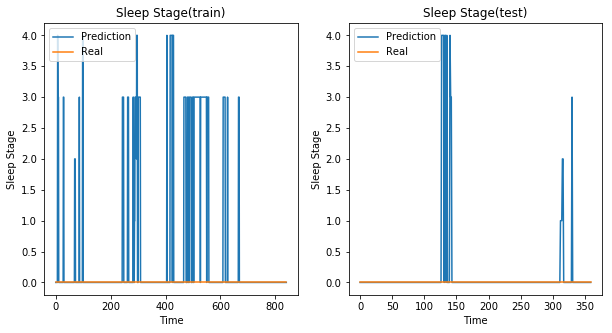

Training duration(s): 10.264681577682495


In [6]:
#X_train, y_train, X_test, y_test, ROH_i_list, Hypoxia_i_list = get_data(
#        path_to_dataset='/home/d500dl/EEG_107/COPD_RAWdata/2018_0515/PSG_SpO2_001.csv',
#            sequence_length=50, ratio=1.0)
run_network(pretrained='weight/180515/PSG_SpO2_001.h5')

-----------------------------
/home/d500dl/EEG_107/COPD_RAWdata/001/PSG_SpO2_001.csv
Loading data...
Data loaded from csv. Formatting...

Amount of stage 4: 0 (There are 4 sleep stage + Wake + REM from old machine.)
Total ROH amount: 0
Total ROH time: 0.0 (s)
ROH index list check: 0
Total time slice amount: 2001
Total data loading time: 0.02541637420654297 (s)

Data Formated.
Compilation Time :  0.03510022163391113
Start training...
Train on 798 samples, validate on 43 samples
Epoch 1/1
798/798 [==============================] - 42s 52ms/step - loss: 9.8939 - mean_absolute_error: 0.9420 - mean_absolute_percentage_error: 768048477.6742 - val_loss: 15.8227 - val_mean_absolute_error: 1.1976 - val_mean_absolute_percentage_error: 1054003408.3721
-----------------------------
(360, 5)
(841, 5)
Training & inference duration (s): 50.74172592163086
REM number: 6
********************
no 0
ROH predicted: 6
ROH GT       : 0
ROH IoU      : 0
ROH precision: 0.0
float division by zero


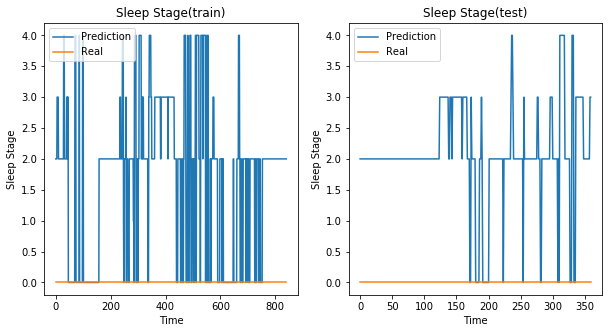

Training duration(s): 51.22570729255676


In [7]:
run_network(training_mode=True)